# M1 Actividad: Robot Cleaner
**Cristian Leilael Rico Espinosa   
Matrícula: A01707023**

## Propósito
Conocer y aplicar una herramienta para la implementación de sistemas multiagentes.

## Contexto
Se trata de una simulación y análisis del comportamiento que robots similares a los *Roomba* tienen cuando estos limpian el suelo.

### Características
* Habitación de M x N espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

### Puntos importantes
* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
**En cada paso de tiempo:**
* Si la celda está sucia, entonces aspira.
* Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

In [1]:
from mesa import Agent, Model

from mesa.space import MultiGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

MAXVAL = 10000

# Definición de Agente

In [2]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        self.nSteps = 1
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.nSteps += 1        
                #print ("Paso ", self.nSteps, " de agente ", self.unique_id)

In [3]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    return grid

# Definición de Modelo

In [4]:
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        print("----- Celdas Sucias Iniciales: ", amount, " -----")
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
        #print(self.floor)        
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Declaración de Simulación.

In [5]:
GRID_SIZE = 20

MAX_GENERATIONS = 200

AGENT_NUMBER = 10

DIRT_PERCENTAGE = 0.7

#Inicialización de variable donde se guardarán las celdas limpias finales.
cCells = 0

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, AGENT_NUMBER, DIRT_PERCENTAGE)
i = 1
j = 0
while i <= MAX_GENERATIONS and not model.is_all_clean():
    model.step()
    i += 1
    j += 1
    
print ("----- Pasos totales al final de ejecución: ", j, " -----")
for x in range (model.grid.width):
    for y in range (model.grid.height):
        if model.floor[x][y] != 1 :
            cCells += 1
print ("----- Celdas Limpias Finales: ", cCells, " -----")

for agent in model.schedule.agents:
    print ("----- El agente ", agent.unique_id, " dió ", agent.nSteps, " pasos -----")

    
# Imprimimos el tiempo que le tomó correr al modelo.
print('----- Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))), " -----")

----- Celdas Sucias Iniciales:  280  -----
----- Pasos totales al final de ejecución:  200  -----
----- Celdas Limpias Finales:  305  -----
----- El agente  0  dió  174  pasos -----
----- El agente  1  dió  171  pasos -----
----- El agente  2  dió  162  pasos -----
----- El agente  3  dió  144  pasos -----
----- El agente  4  dió  166  pasos -----
----- El agente  5  dió  148  pasos -----
----- El agente  6  dió  158  pasos -----
----- El agente  7  dió  152  pasos -----
----- El agente  8  dió  175  pasos -----
----- El agente  9  dió  150  pasos -----
----- Tiempo de ejecución: 0:00:00.057704  -----


In [6]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

# Visualización

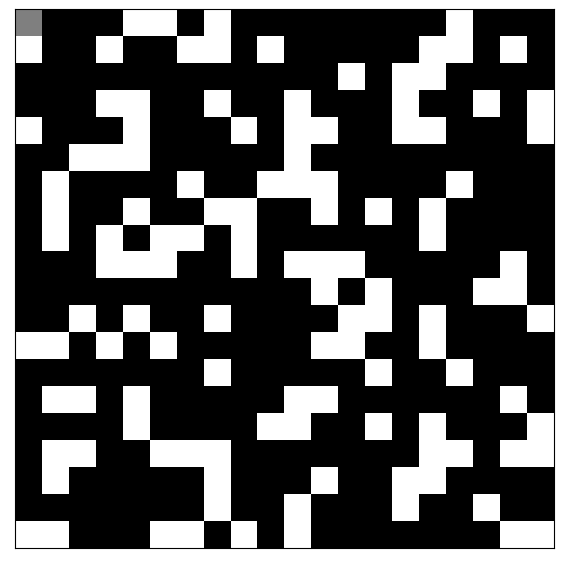

In [7]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

# Animación

In [8]:
def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)
anim